#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션①
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.


### (2) 미션②  
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다.
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* 변수 중요도 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [ ]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용 데이터셋
    * feature.csv : feature 이름을 계층구조로 정리한 데이터  
 <br/>
    

* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 변수에 저장합니다.
    - 센서 그룹 데이터 'feature.csv' 를 불러와 'features' 변수에 저장합니다.

In [ ]:
import os
path = '/content/drive/MyDrive/2023.10.25_미니프로젝트5차_데이터 및 실습자료'

data = pd.read_csv(os.path.join(path+'/data01_train.csv'))
features = pd.read_csv(os.path.join(path + '/features.csv'))

In [ ]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS


In [ ]:
features.head()

,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [ ]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594,17.381568
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479,8.938316
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143,1.000000
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555,8.000000
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951,19.000000
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932,26.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000,30.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 25.3+ MB


In [ ]:
data.dtypes

tBodyAcc-mean()-X       float64
tBodyAcc-mean()-Y       float64
tBodyAcc-mean()-Z       float64
tBodyAcc-std()-X        float64
tBodyAcc-std()-Y        float64
                         ...   
angle(X,gravityMean)    float64
angle(Y,gravityMean)    float64
angle(Z,gravityMean)    float64
subject                   int64
Activity                 object
Length: 563, dtype: object

### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [ ]:
data['Activity'].unique()

array(['STANDING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS', 'SITTING'], dtype=object)

In [ ]:
data['Activity'].value_counts()

LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: Activity, dtype: int64

In [ ]:
data['Activity'].value_counts(normalize=True)

LAYING                0.189594
STANDING              0.184833
SITTING               0.175480
WALKING               0.169699
WALKING_UPSTAIRS      0.145894
WALKING_DOWNSTAIRS    0.134501
Name: Activity, dtype: float64

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [ ]:
features['sensor'].value_counts()

fBodyGyro               79
fBodyAcc                79
fBodyAccJerk            79
tBodyAcc                40
tBodyAccJerk            40
tBodyGyro               40
tBodyGyroJerk           40
tGravityAcc             40
fBodyBodyGyroJerkMag    13
fBodyBodyGyroMag        13
fBodyBodyAccJerkMag     13
fBodyAccMag             13
tBodyGyroJerkMag        13
tBodyGyroMag            13
tBodyAccJerkMag         13
tGravityAccMag          13
tBodyAccMag             13
angle                    7
Name: sensor, dtype: int64

In [ ]:
features['agg'].value_counts()

bandsEnergy()        126
arCoeff()             60
mean()                33
mad()                 33
max()                 33
min()                 33
energy()              33
iqr()                 33
entropy()             33
std()                 33
sma()                 17
correlation()         15
meanFreq()            13
kurtosis()            13
skewness()            13
maxInds               13
arCoeff()3             5
arCoeff()4             5
arCoeff()2             5
arCoeff()1             5
tBodyAccMean           1
tBodyAccJerkMean       1
tBodyGyroMean          1
tBodyGyroJerkMean      1
X                      1
Y                      1
Z                      1
Name: agg, dtype: int64

In [ ]:
features['axis'].value_counts()

X              76
Y              76
Z              76
gravityMean     6
X,2             5
               ..
25,32.1         2
17,24.1         2
1,8.1           2
9,16.1          2
gravity         1
Name: axis, Length: 62, dtype: int64

## 3.데이터 분석 : 미션1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

In [ ]:
y = data['Activity']
x = data.drop('Activity', axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

In [ ]:
result = plot_feature_importance(model.feature_importances_, list(x), 10)

In [ ]:
cum_importance = []
cum = 0
for i in range(len(result)):
    if cum >= 0.4:
        break
    cum += result.loc[i, 'feature_importance']
    cum_importance.append(cum)

In [ ]:
len(cum_importance)

25

In [ ]:
result.head(24)

,feature_name,feature_importance
0,tGravityAcc-min()-X,0.034336
1,tGravityAcc-energy()-X,0.030946
2,"angle(Y,gravityMean)",0.030924
3,tGravityAcc-max()-Y,0.026646
4,"angle(X,gravityMean)",0.026251
5,tGravityAcc-mean()-Y,0.025775
6,tGravityAcc-min()-Y,0.024740
7,tGravityAcc-max()-X,0.019630
8,tGravityAcc-energy()-Y,0.018285
9,tGravityAcc-mean()-X,0.017185


In [ ]:
result.tail(12)

,feature_name,feature_importance
550,fBodyAcc-maxInds-Z,0.000097
551,fBodyAccJerk-kurtosis()-Z,0.000097
552,"fBodyAccJerk-bandsEnergy()-49,64.1",0.000092
553,"tBodyAcc-arCoeff()-Z,3",0.000089
554,"tBodyAcc-arCoeff()-Y,3",0.000088
555,tBodyGyroJerk-entropy()-Y,0.000083
556,"fBodyAcc-bandsEnergy()-49,64.2",0.000077
557,fBodyAccJerk-min()-X,0.000076
558,fBodyAccJerk-meanFreq()-Y,0.000072
559,"tBodyGyro-arCoeff()-Z,1",0.000070


### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

In [ ]:
top24 = list(result.feature_name[:24])
bot24 = list(result.feature_name[-24:])

In [ ]:
len(bot24)

24

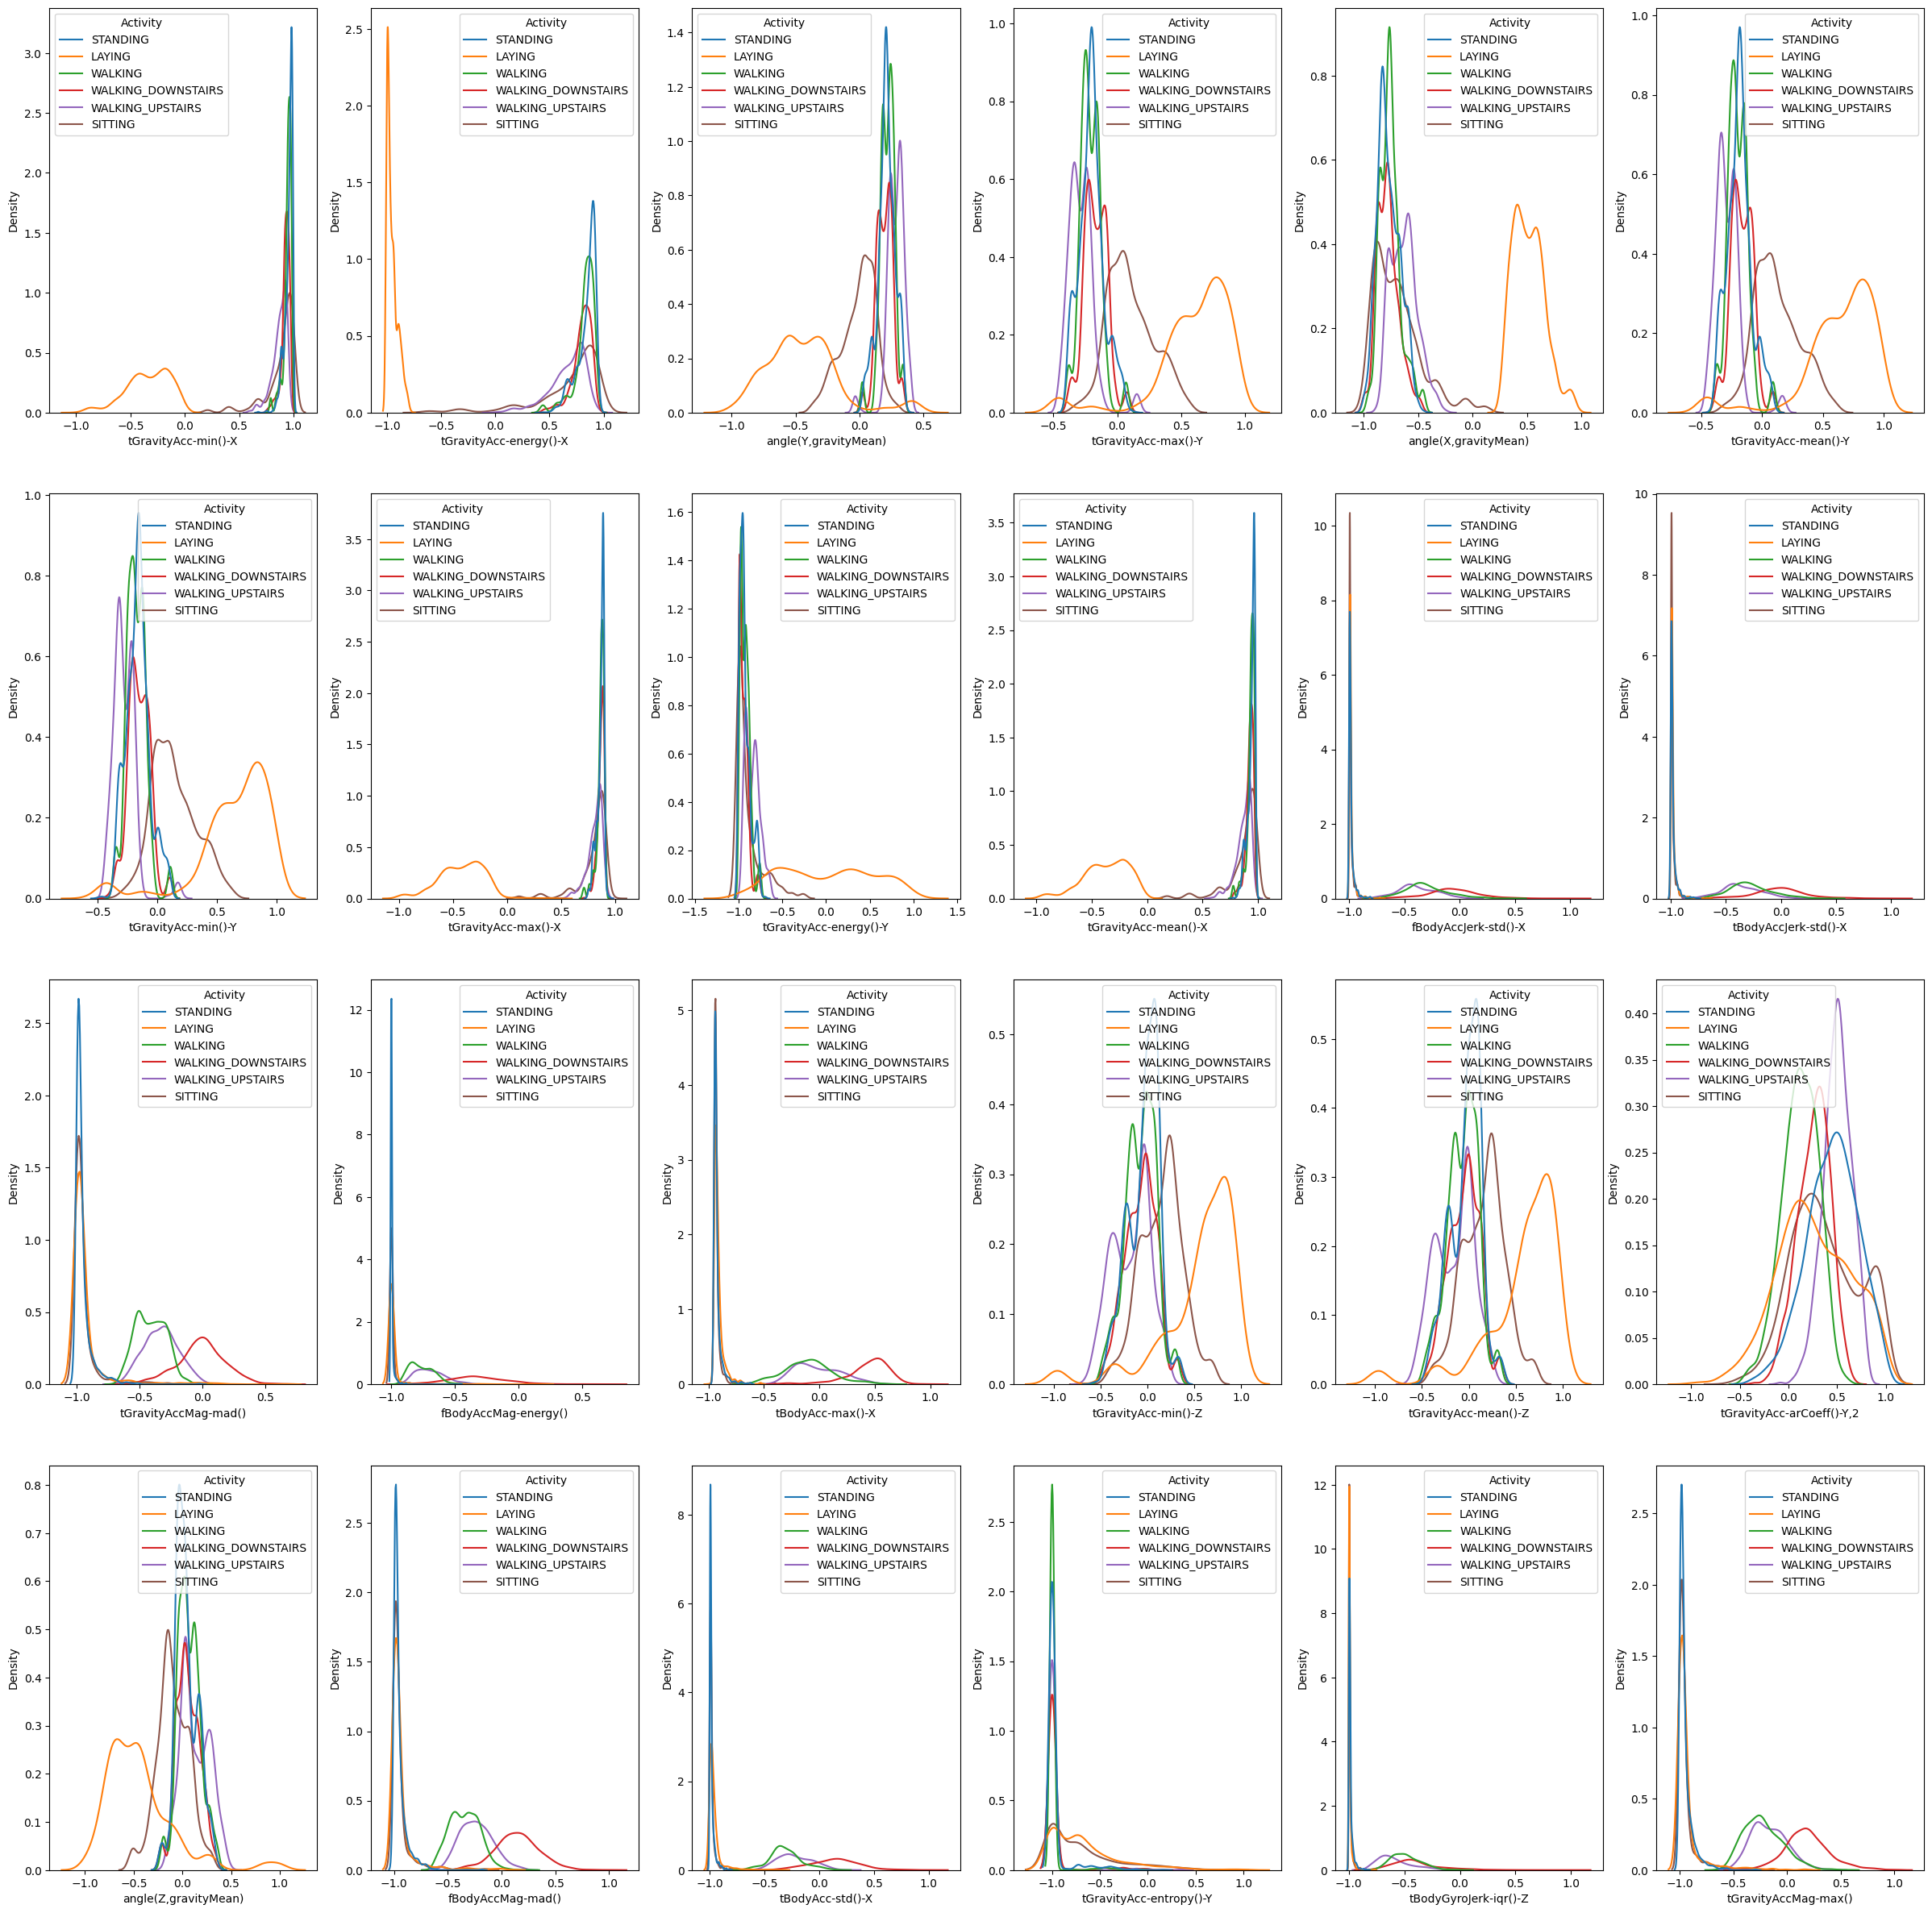

In [ ]:
plt.figure(figsize=(30, 30))
for i in range(24):
    plt.subplot(4, 6, i+1)
    sns.kdeplot(x=top24[i], hue='Activity', data=data)

In [ ]:
# TOP24 - 인덱스 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 15, 17, 19 가 그나마 경향을 잘 반영하는 것 같다.
# 특히 0~8, 10, 13, 17, 19 laying을 구분하는데 도움이,
# 11, 15는 동적, 정적 행동을 구분하는데 도움이 되는 것 같다.

In [ ]:
print(top24[0:9])
print(top24[10:12])
print(top24[13:21:2])

# tGravityAcc, angle, fBodyAccMag 이 세 변수가 중요해 보이며,
# 경향 반영은 tBodyACC, fBodyAccMag의 표준편차가 주 역할을 한 것으로 보인다.

['tGravityAcc-min()-X', 'tGravityAcc-energy()-X', 'angle(Y,gravityMean)', 'tGravityAcc-max()-Y', 'angle(X,gravityMean)', 'tGravityAcc-mean()-Y', 'tGravityAcc-min()-Y', 'tGravityAcc-max()-X', 'tGravityAcc-energy()-Y']
['fBodyAccJerk-std()-X', 'tBodyAccJerk-std()-X']
['fBodyAccMag-energy()', 'tGravityAcc-min()-Z', 'tGravityAcc-arCoeff()-Y,2', 'fBodyAccMag-mad()']


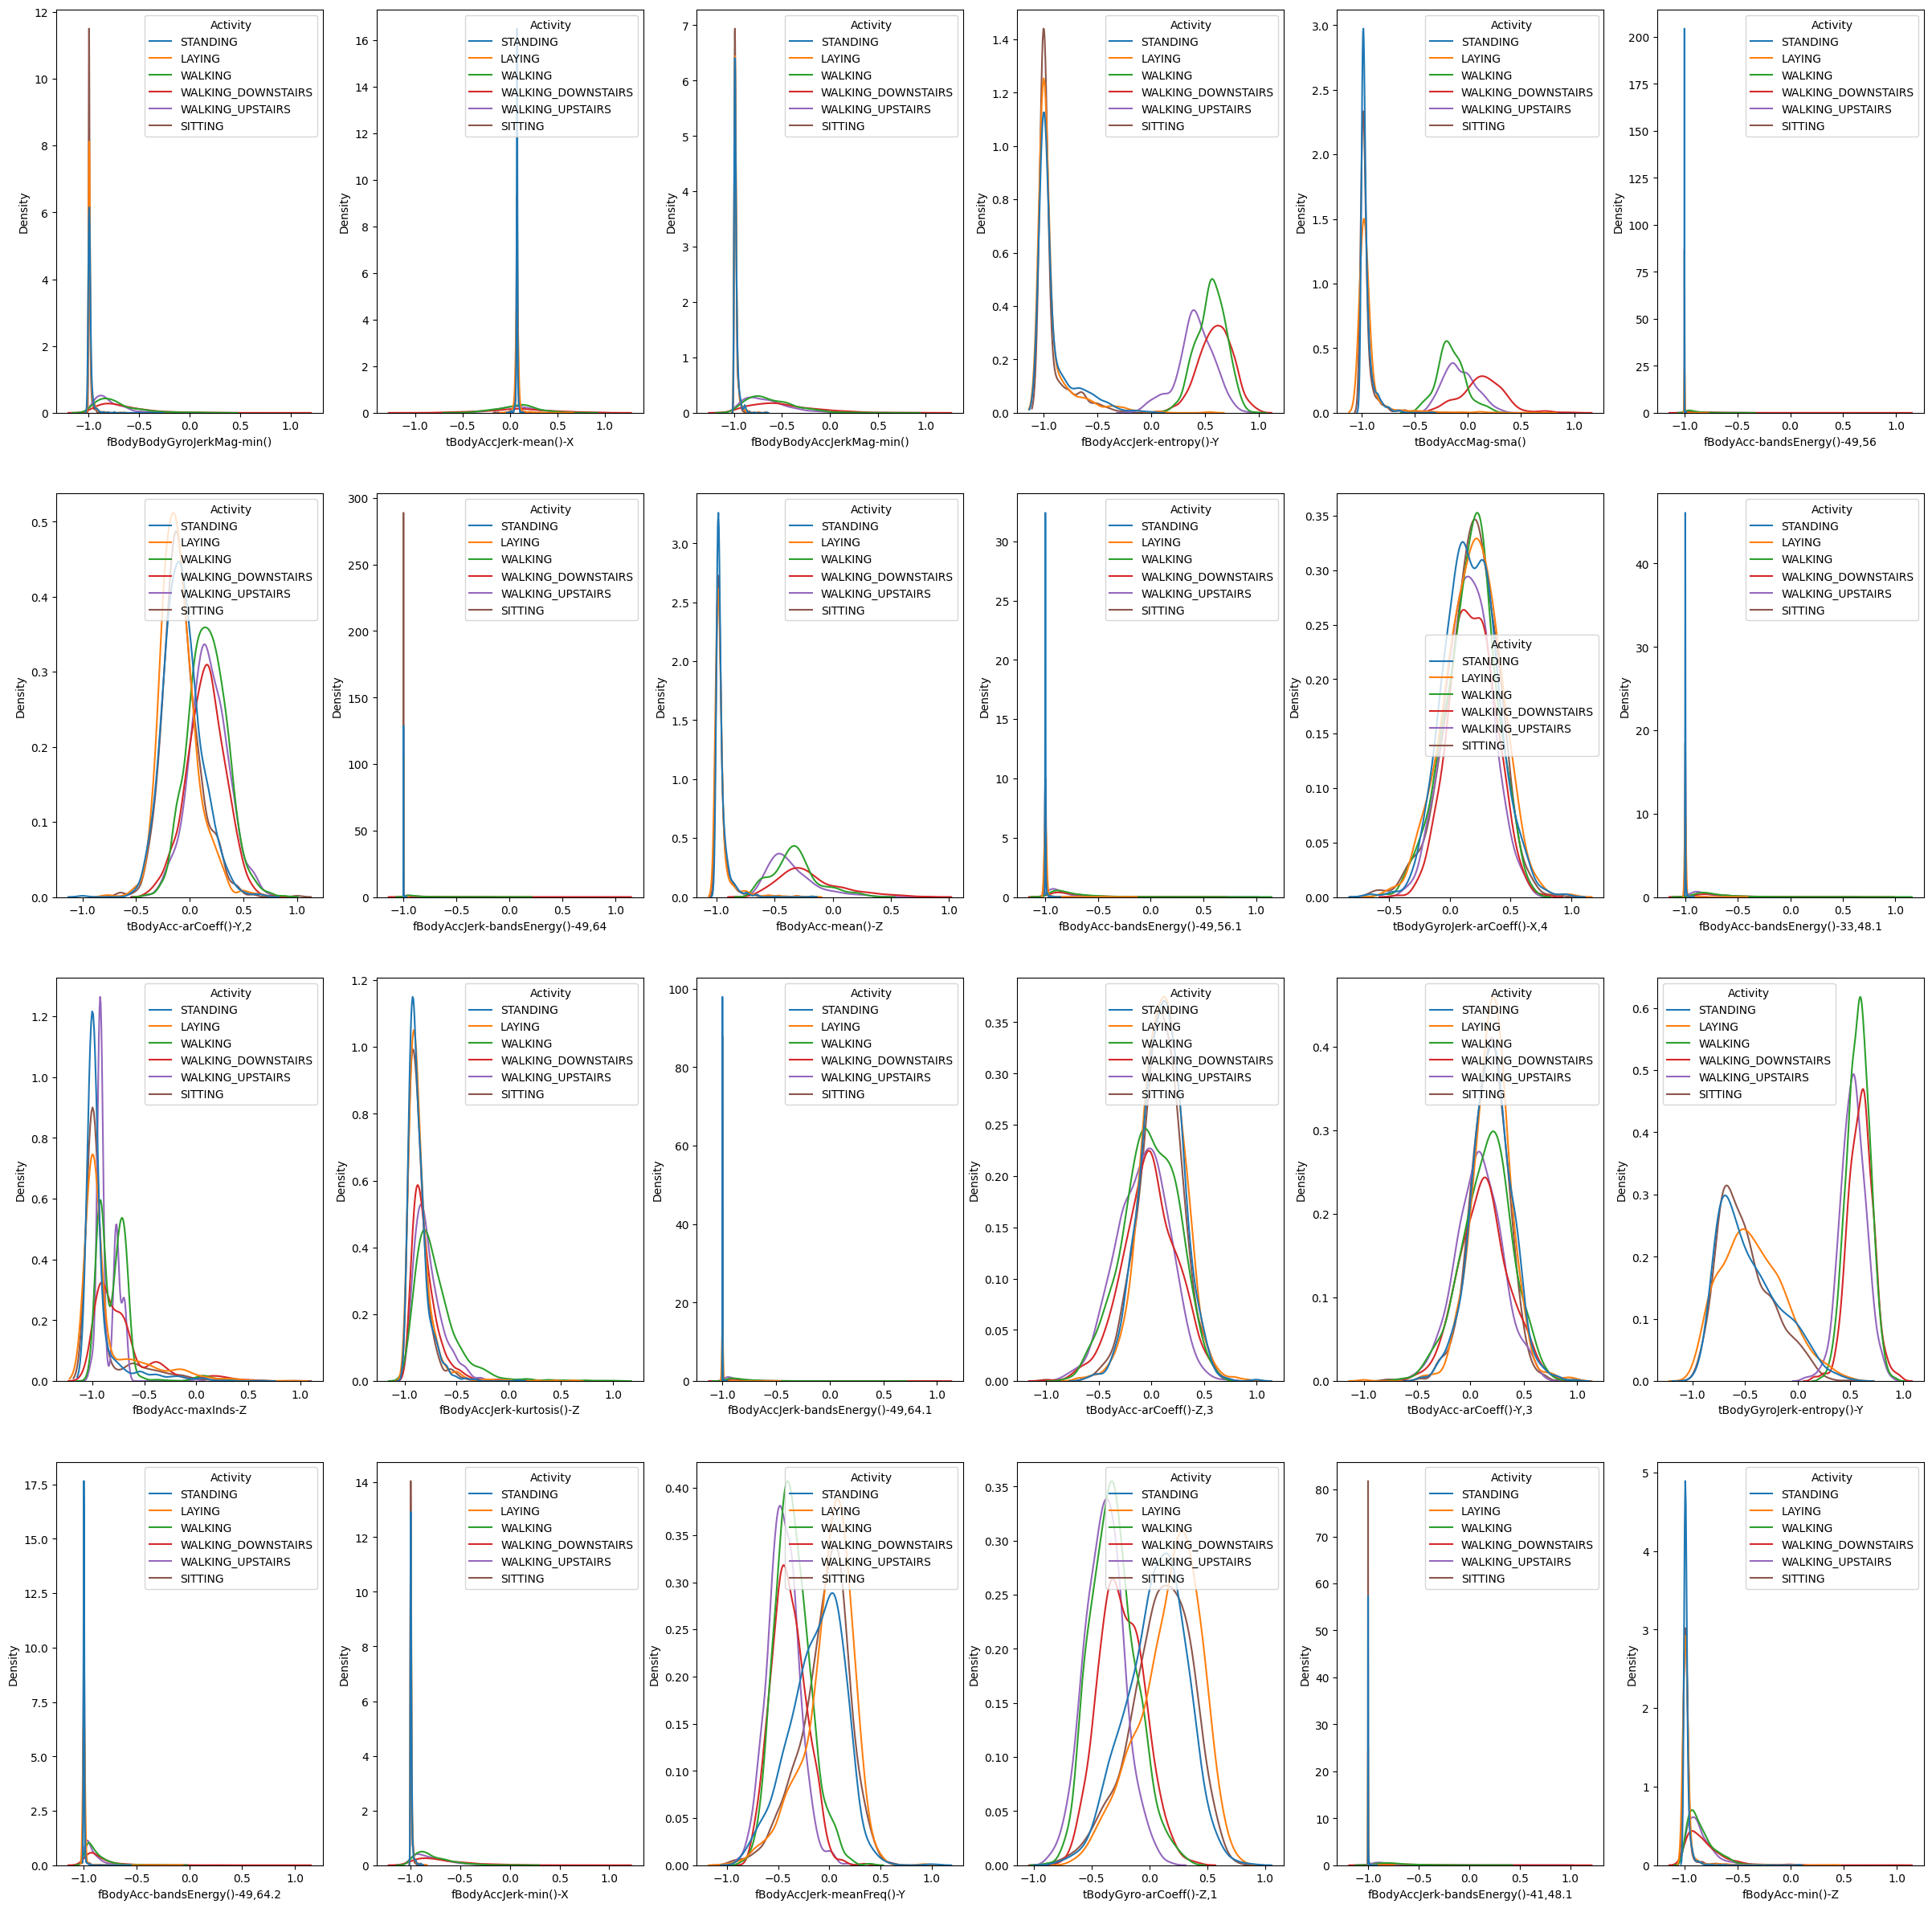

In [ ]:
plt.figure(figsize=(30, 30))
for i in range(24):
    plt.subplot(4, 6, i+1)
    sns.kdeplot(x=bot24[i], hue='Activity', data=data)

In [ ]:
# 인덱스 2, 3, 5, 8, 11, 20, 22, 23이 그나마 정적 자세, 부동 자세에 있어서 분포의 약간의 차이를 보인다.
# 특히 2, 3, 5, 8, 11, 20 의 경우 정적 자세는 완전히 -1 쪽 값이 고정인 반면, 동적 자세는 약간의 퍼져있는 분포를 보인다.
# 22, 23의 경우 두 자세가 분포가 비슷한 군으로 다르게 그려지는 것을 알 수 있다. (둘을 구분하는데는 22, 23이 가장 유익한 변수로 판단된다.)

In [ ]:
print(bot24[2:4])
print(bot24[5:14:3])
print(bot24[20:24:2])
print(bot24[23])

# fBodyAccJerk와 fBodyAcc, fBodyAcc-bandsEnergy, fBodyBodyGyroJerkMag 은 약간의 퍼지고, 안퍼진 정도를 반영
# fBodyAccMag, fBodyBodyGyroJerkMag는 정적/동적 자세를 구분하는데 기여

['fBodyBodyAccJerkMag-min()', 'fBodyAccJerk-entropy()-Y']
['fBodyAcc-bandsEnergy()-49,56', 'fBodyAcc-mean()-Z', 'fBodyAcc-bandsEnergy()-33,48.1']
['fBodyAccJerk-meanFreq()-Y', 'fBodyAccJerk-bandsEnergy()-41,48.1']
fBodyAcc-min()-Z


### (3) feature 그룹별 분석

* **세부 요구사항**
    - 제공된 features.csv 에는 feature에 대한 계층구조를 정리해 놓았습니다.
    - features와 변수중요도 결과를 merge 하시오.
    - sensor 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.
    - sensor + agg 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.


In [ ]:
result = pd.merge(result, features, on='feature_name')

In [ ]:
result.head()

,feature_name,feature_importance,sensor,agg,axis
0,tGravityAcc-min()-X,0.034336,tGravityAcc,min(),X
1,tGravityAcc-energy()-X,0.030946,tGravityAcc,energy(),X
2,"angle(Y,gravityMean)",0.030924,angle,Y,gravityMean
3,tGravityAcc-max()-Y,0.026646,tGravityAcc,max(),Y
4,"angle(X,gravityMean)",0.026251,angle,X,gravityMean


<Axes: ylabel='sensor'>

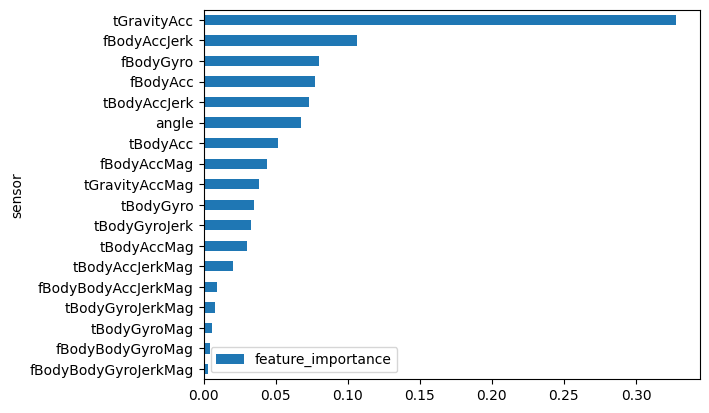

In [ ]:
result.groupby('sensor')['feature_importance'].sum().reset_index().sort_values(by='feature_importance').plot.barh(x='sensor')

<Axes: ylabel='sensor'>

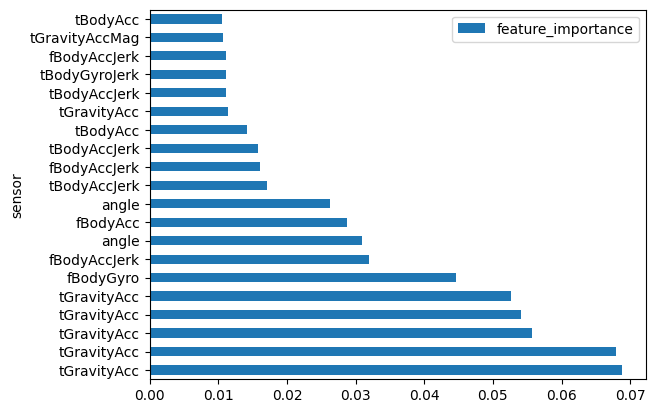

In [ ]:
result.groupby(['sensor', 'agg'])['feature_importance'].sum().reset_index().sort_values(by='feature_importance', ascending=False).head(20).plot.barh(x='sensor')

## 4.데이터 분석 : 미션2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다.
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [ ]:
data['is_dynamic'] = data['Activity'].map({'STANDING' : 0, 'SITTING' : 0, 'LAYING' : 0, 'WALKING' : 1, 'WALKING_UPSTAIRS' : 1, 'WALKING_DOWNSTAIRS' : 1})

In [ ]:
data['is_dynamic'].value_counts()

0    3234
1    2647
Name: is_dynamic, dtype: int64

#### 2) 기본모델 생성

In [ ]:
drop_cols = ['Activity']

In [ ]:
var = 'is_dynamic'
y = data[var]
drop_cols.append(var)
x = data.drop(drop_cols, axis=1)

In [ ]:
x.shape

(5881, 562)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

In [ ]:
result_dyn = plot_feature_importance(model.feature_importances_, list(x), 10)

#### 3) 변수중요도 상위 5개 분석

In [ ]:
result_dyn

,feature_name,feature_importance
0,fBodyAccJerk-energy()-X,0.069810
1,"fBodyAccJerk-bandsEnergy()-1,16",0.050384
2,tBodyAccJerk-energy()-X,0.049948
3,tBodyAccJerkMag-sma(),0.049889
4,"fBodyAccJerk-bandsEnergy()-1,24",0.049872
...,...,...
557,tBodyGyroMag-arCoeff()4,0.000000
558,tBodyGyroMag-arCoeff()3,0.000000
559,tBodyGyroMag-arCoeff()1,0.000000
560,tBodyGyroMag-entropy(),0.000000


In [ ]:
result_dyn = pd.merge(result_dyn, features, on='feature_name')

#### 4) feature 그룹별 분석

<Axes: ylabel='sensor'>

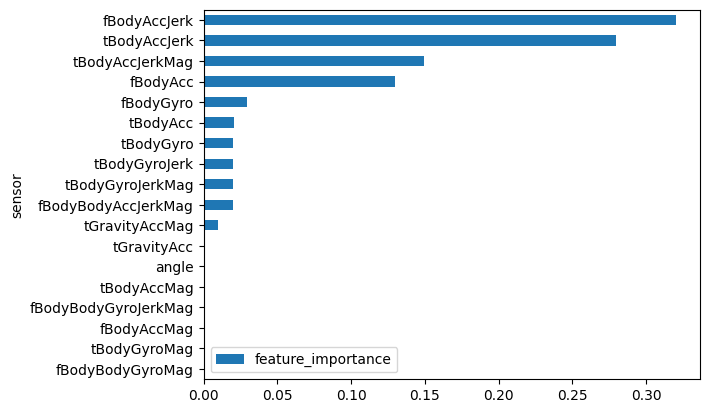

In [ ]:
result_dyn.groupby('sensor')['feature_importance'].sum().reset_index().sort_values(by='feature_importance').plot.barh(x='sensor')

<Axes: ylabel='sensor'>

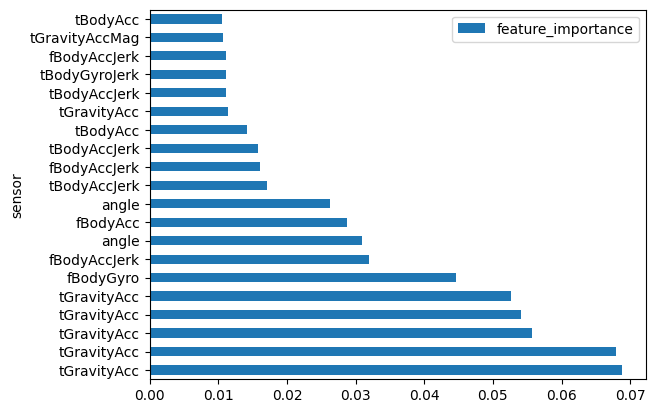

In [ ]:
result.groupby(['sensor', 'agg'])['feature_importance'].sum().reset_index().sort_values(by='feature_importance', ascending=False).head(20).plot.barh(x='sensor')

### (2) 개별 동작 분석 : is_standing


* **세부 요구사항**
    - Target인 Activity를 is_standing 변수로 변경하시오.
        * 값 1 : STANDING
        * 값 0 : 나머지
    - is_standing 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_standing 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_standing 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_standing 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [ ]:
data['is_standing'] = data['Activity'].map({'STANDING' : 1, 'SITTING' : 0, 'LAYING' : 0, 'WALKING' : 0, 'WALKING_UPSTAIRS' : 0, 'WALKING_DOWNSTAIRS' : 0})

In [ ]:
data['is_standing'].value_counts()

0    4794
1    1087
Name: is_standing, dtype: int64

In [ ]:
var = 'is_standing'
y = data[var]
drop_cols.append(var)
x = data.drop(drop_cols, axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

In [ ]:
result_stand = plot_feature_importance(model.feature_importances_, list(x), 10)

In [ ]:
result_stand = pd.merge(result_stand, features, on='feature_name')

<Axes: ylabel='sensor'>

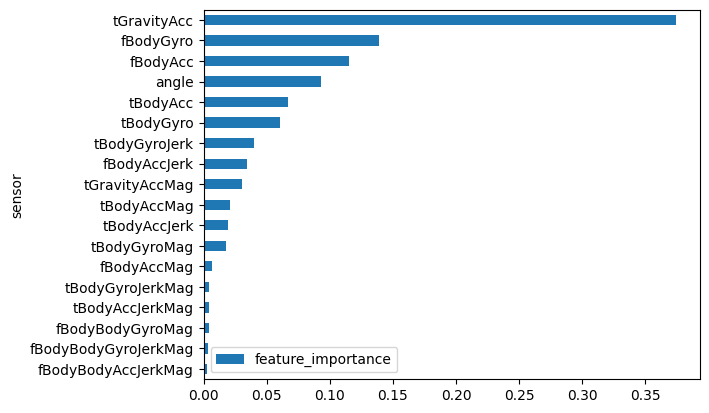

In [ ]:
result_stand.groupby('sensor')['feature_importance'].sum().reset_index().sort_values(by='feature_importance').plot.barh(x='sensor')

<Axes: ylabel='sensor'>

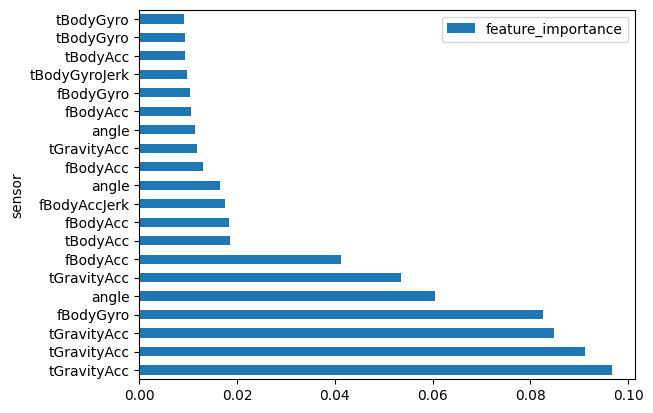

In [ ]:
result_stand.groupby(['sensor', 'agg'])['feature_importance'].sum().reset_index().sort_values(by='feature_importance', ascending=False).head(20).plot.barh(x='sensor')

### (3) 개별 동작 분석 : is_sitting


* **세부 요구사항**
    - Target인 Activity를 is_sitting 변수로 변경하시오.
        * 값 1 : SITTING
        * 값 0 : 나머지
    - is_sitting 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_sitting 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_sitting 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_sitting 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [ ]:
data['is_sitting'] = data['Activity'].map({'STANDING' : 0, 'SITTING' : 1, 'LAYING' : 0, 'WALKING' : 0, 'WALKING_UPSTAIRS' : 0, 'WALKING_DOWNSTAIRS' : 0})

In [ ]:
data['is_sitting'].value_counts()

0    4849
1    1032
Name: is_sitting, dtype: int64

In [ ]:
var = 'is_sitting'
y = data[var]
drop_cols.append(var)
x = data.drop(drop_cols, axis=1)

In [ ]:
x.shape

(5881, 562)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

In [ ]:
result_sit = plot_feature_importance(model.feature_importances_, list(x), 10)

In [ ]:
result_sit = pd.merge(result_sit, features, on='feature_name')

<Axes: ylabel='sensor'>

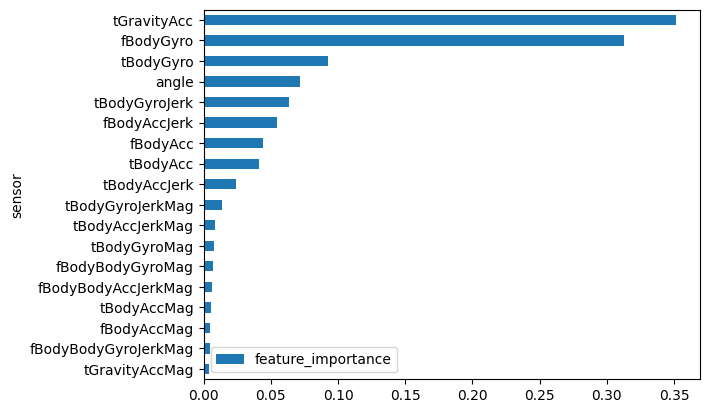

In [ ]:
result_sit.groupby('sensor')['feature_importance'].sum().reset_index().sort_values(by='feature_importance').plot.barh(x='sensor')

<Axes: ylabel='sensor'>

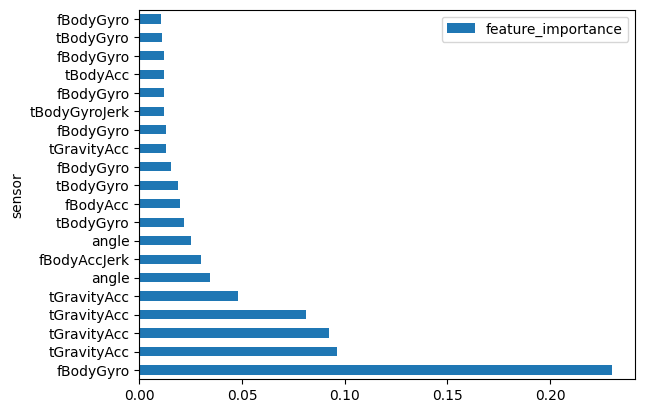

In [ ]:
result_sit.groupby(['sensor', 'agg'])['feature_importance'].sum().reset_index().sort_values(by='feature_importance', ascending=False).head(20).plot.barh(x='sensor')

### (4) 개별 동작 분석 : is_laying


* **세부 요구사항**
    - Target인 Activity를 is_laying 변수로 변경하시오.
        * 값 1 : LAYING
        * 값 0 : 나머지
    - is_laying 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_laying 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_laying 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_laying 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [ ]:
data['is_laying'] = data['Activity'].map({'STANDING' : 0, 'SITTING' : 0, 'LAYING' : 1, 'WALKING' : 0, 'WALKING_UPSTAIRS' : 0, 'WALKING_DOWNSTAIRS' : 0})

In [ ]:
data['is_laying'].value_counts()

0    4766
1    1115
Name: is_laying, dtype: int64

In [ ]:
var = 'is_laying'
y = data[var]
drop_cols.append(var)
x = data.drop(drop_cols, axis=1)

In [ ]:
x.shape

(5881, 562)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

In [ ]:
result_lay = plot_feature_importance(model.feature_importances_, list(x), 10)

In [ ]:
result_lay = pd.merge(result_lay, features, on='feature_name')

<Axes: ylabel='sensor'>

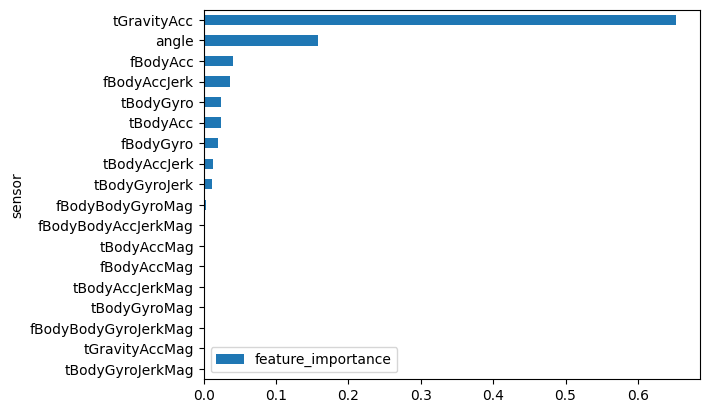

In [ ]:
result_lay.groupby('sensor')['feature_importance'].sum().reset_index().sort_values(by='feature_importance').plot.barh(x='sensor')

<Axes: ylabel='sensor'>

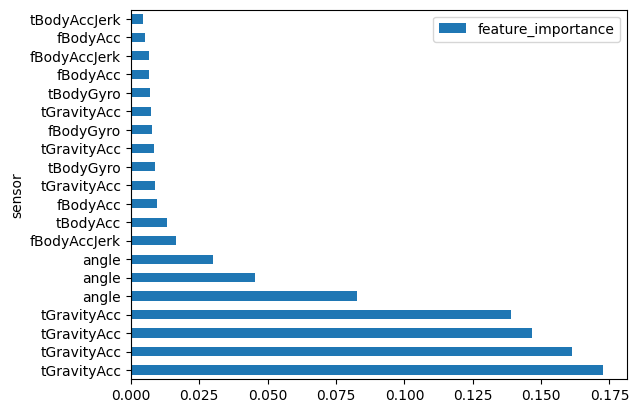

In [ ]:
result_lay.groupby(['sensor', 'agg'])['feature_importance'].sum().reset_index().sort_values(by='feature_importance', ascending=False).head(20).plot.barh(x='sensor')

### (5) 개별 동작 분석 : is_walking


* **세부 요구사항**
    - Target인 Activity를 is_walking 변수로 변경하시오.
        * 값 1 : WALKING
        * 값 0 : 나머지
    - is_walking 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [ ]:
data['is_walking'] = data['Activity'].map({'STANDING' : 0, 'SITTING' : 0, 'LAYING' : 0, 'WALKING' : 1, 'WALKING_UPSTAIRS' : 0, 'WALKING_DOWNSTAIRS' : 0})

In [ ]:
data['is_walking'].value_counts()

0    4883
1     998
Name: is_walking, dtype: int64

In [ ]:
var = 'is_walking'
y = data[var]
drop_cols.append(var)
x = data.drop(drop_cols, axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

<Axes: ylabel='sensor'>

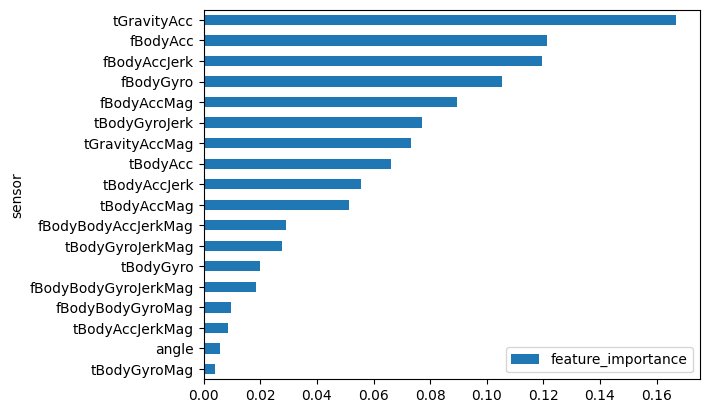

In [ ]:
result_walk = plot_feature_importance(model.feature_importances_, list(x), 10)
result_walk = pd.merge(result_walk, features, on='feature_name')
result_walk.groupby('sensor')['feature_importance'].sum().reset_index().sort_values(by='feature_importance').plot.barh(x='sensor')

<Axes: ylabel='sensor'>

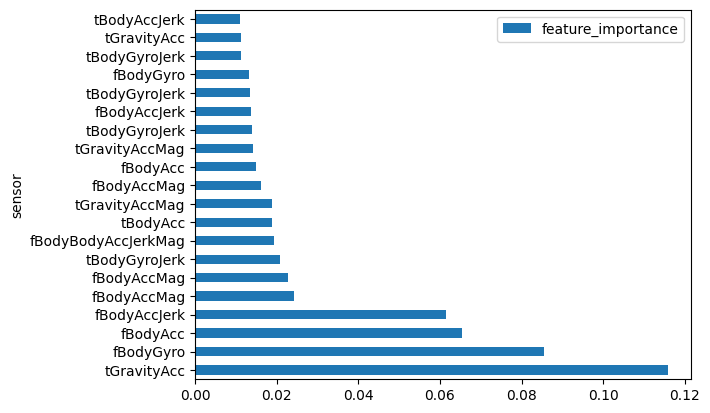

In [ ]:
result_walk.groupby(['sensor', 'agg'])['feature_importance'].sum().reset_index().sort_values(by='feature_importance', ascending=False).head(20).plot.barh(x='sensor')

### (6) 개별 동작 분석 : is_walking_up


* **세부 요구사항**
    - Target인 Activity를 is_walking_up 변수로 변경하시오.
        * 값 1 : WALKING_UPSTAIRS
        * 값 0 : 나머지
    - is_walking_up 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_up 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_up 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_up 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [ ]:
data['is_walking_up'] = data['Activity'].map({'STANDING' : 0, 'SITTING' : 0, 'LAYING' : 0, 'WALKING' : 0, 'WALKING_UPSTAIRS' : 1, 'WALKING_DOWNSTAIRS' : 0})

In [ ]:
data['is_walking_up'].value_counts()

0    5023
1     858
Name: is_walking_up, dtype: int64

In [ ]:
var = 'is_walking_up'
y = data[var]
drop_cols.append(var)
x = data.drop(drop_cols, axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

<Axes: ylabel='sensor'>

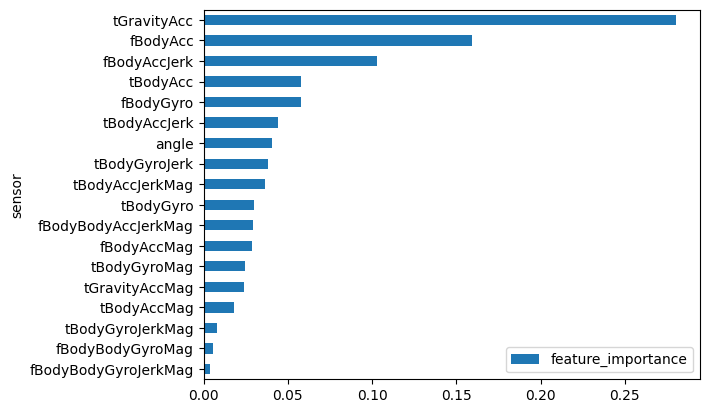

In [ ]:
result_walk_up = plot_feature_importance(model.feature_importances_, list(x), 10)
result_walk_up = pd.merge(result_walk_up, features, on='feature_name')
result_walk_up.groupby('sensor')['feature_importance'].sum().reset_index().sort_values(by='feature_importance').plot.barh(x='sensor')

<Axes: ylabel='sensor'>

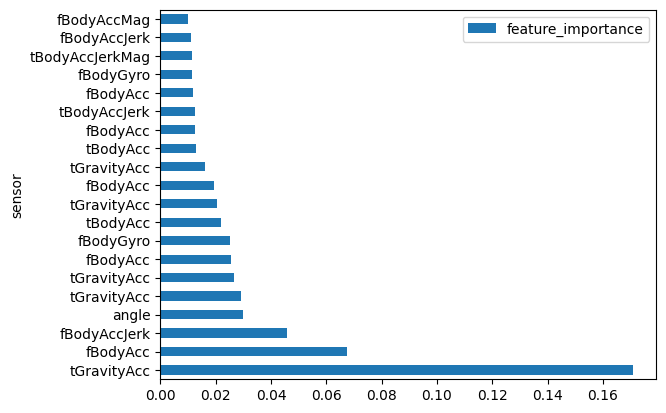

In [ ]:
result_walk_up.groupby(['sensor', 'agg'])['feature_importance'].sum().reset_index().sort_values(by='feature_importance', ascending=False).head(20).plot.barh(x='sensor')

### (7) 개별 동작 분석 : is_walking_down


* **세부 요구사항**
    - Target인 Activity를 is_walking_down 변수로 변경하시오.
        * 값 1 : WALKING_DOWNSTAIRS
        * 값 0 : 나머지
    - is_walking_down 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_down 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_down 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_down 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [ ]:
data['is_walking_down'] = data['Activity'].map({'STANDING' : 0, 'SITTING' : 0, 'LAYING' : 0, 'WALKING' : 0, 'WALKING_UPSTAIRS' : 0, 'WALKING_DOWNSTAIRS' : 1})

In [ ]:
data['is_walking_down'].value_counts()

0    5090
1     791
Name: is_walking_down, dtype: int64

In [ ]:
var = 'is_walking_down'
y = data[var]
drop_cols.append(var)
x = data.drop(drop_cols, axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

<Axes: ylabel='sensor'>

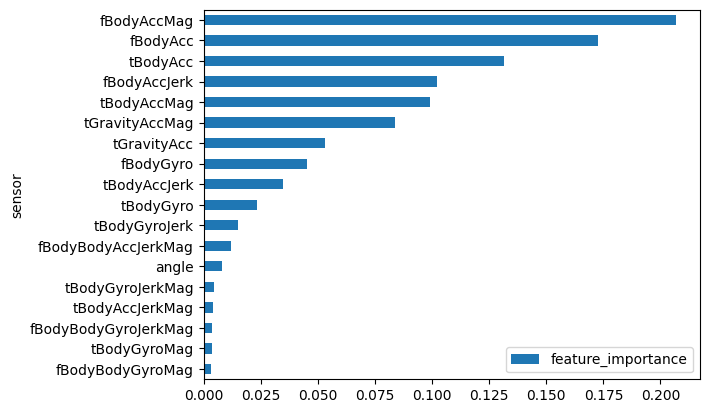

In [ ]:
result_walk_down = plot_feature_importance(model.feature_importances_, list(x), 10)
result_walk_down = pd.merge(result_walk_down, features, on='feature_name')
result_walk_down.groupby('sensor')['feature_importance'].sum().reset_index().sort_values(by='feature_importance').plot.barh(x='sensor')

<Axes: ylabel='sensor'>

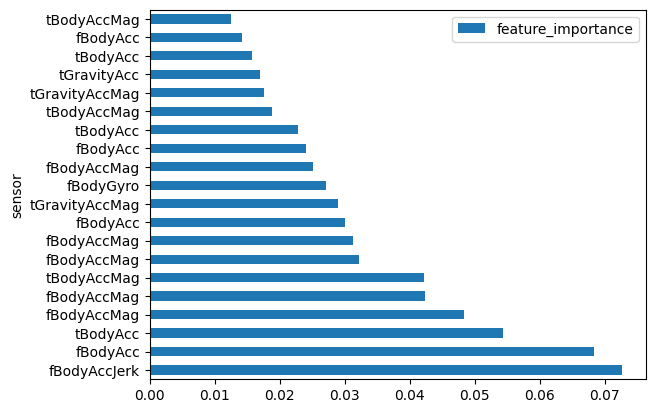

In [ ]:
result_walk_down.groupby(['sensor', 'agg'])['feature_importance'].sum().reset_index().sort_values(by='feature_importance', ascending=False).head(20).plot.barh(x='sensor')

## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
        - 관점3 : Standing 여부 구분
        - 관점4 : Sitting 여부 구분
        - 관점5 : Laying 여부 구분
        - 관점6 : Walking 여부 구분
        - 관점7 : Walking_upstairs 여부 구분
        - 관점8 : Walking_downstairs 여부 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

In [ ]:
features

,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y
...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)"
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)"
558,angle,X,gravityMean,"angle(X,gravityMean)"
559,angle,Y,gravityMean,"angle(Y,gravityMean)"


In [ ]:
result

,feature_name,feature_importance,sensor,agg,axis
0,tGravityAcc-min()-X,0.034336,tGravityAcc,min(),X
1,tGravityAcc-energy()-X,0.030946,tGravityAcc,energy(),X
2,"angle(Y,gravityMean)",0.030924,angle,Y,gravityMean
3,tGravityAcc-max()-Y,0.026646,tGravityAcc,max(),Y
4,"angle(X,gravityMean)",0.026251,angle,X,gravityMean
...,...,...,...,...,...
556,fBodyAccJerk-min()-X,0.000076,fBodyAccJerk,min(),X
557,fBodyAccJerk-meanFreq()-Y,0.000072,fBodyAccJerk,meanFreq(),Y
558,"tBodyGyro-arCoeff()-Z,1",0.000070,tBodyGyro,arCoeff(),"Z,1"
559,"fBodyAccJerk-bandsEnergy()-41,48.1",0.000068,fBodyAccJerk,bandsEnergy(),"41,48.1"


In [ ]:
result_tmp = pd.merge(result, result_dyn, on=['feature_name', 'sensor', 'agg', 'axis'])
result_tmp = pd.merge(result_tmp, result_stand, on=['feature_name', 'sensor', 'agg', 'axis'])
result_tmp = pd.merge(result_tmp, result_sit, on=['feature_name', 'sensor', 'agg', 'axis'])
result_tmp = pd.merge(result_tmp, result_lay, on=['feature_name', 'sensor', 'agg', 'axis'])
result_tmp = pd.merge(result_tmp, result_walk, on=['feature_name', 'sensor', 'agg', 'axis'])
result_tmp = pd.merge(result_tmp, result_walk_up, on=['feature_name', 'sensor', 'agg', 'axis'])
result_tmp = pd.merge(result_tmp, result_walk_down, on=['feature_name', 'sensor', 'agg', 'axis'])

<ipython-input-456-60ac02460a8b>:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'feature_importance_x'} in the result is deprecated and will raise a MergeError in a future version.
  result_tmp = pd.merge(result_tmp, result_sit, on=['feature_name', 'sensor', 'agg', 'axis'])
<ipython-input-456-60ac02460a8b>:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'feature_importance_x'} in the result is deprecated and will raise a MergeError in a future version.
  result_tmp = pd.merge(result_tmp, result_walk, on=['feature_name', 'sensor', 'agg', 'axis'])
<ipython-input-456-60ac02460a8b>:7: FutureWarning: Passing 'suffixes' which cause duplicate columns {'feature_importance_x'} in the result is deprecated and will raise a MergeError in a future version.
  result_tmp = pd.merge(result_tmp, result_walk_down, on=['feature_name', 'sensor', 'agg', 'axis'])


In [ ]:
result_tmp.columns = ['feature_name', 'feature_importance_all', 'sensor', 'agg', 'axis', 'feature_importance_dyn', 'feature_importance_stand', 'feature_importance_sit', 'feature_importance_lay', 'feature_importance_walk', 'feature_importance_walk_up', 'feature_importance_walk_down']

In [ ]:
result_all = result_tmp[['feature_name', 'sensor', 'agg', 'axis', 'feature_importance_all', 'feature_importance_dyn', 'feature_importance_stand', 'feature_importance_sit', 'feature_importance_lay', 'feature_importance_walk', 'feature_importance_walk_up', 'feature_importance_walk_down']]

In [ ]:
result_all

,feature_name,sensor,agg,axis,feature_importance_all,feature_importance_dyn,feature_importance_stand,feature_importance_sit,feature_importance_lay,feature_importance_walk,feature_importance_walk_up,feature_importance_walk_down
0,tGravityAcc-min()-X,tGravityAcc,min(),X,0.034336,0.000034,0.016959,0.026272,0.063912,0.003940,0.003326,0.000785
1,tGravityAcc-energy()-X,tGravityAcc,energy(),X,0.030946,0.000009,0.028427,0.023411,0.072634,0.001980,0.006499,0.001245
2,"angle(Y,gravityMean)",angle,Y,gravityMean,0.030924,0.000034,0.060445,0.034539,0.045372,0.001662,0.029911,0.003991
3,tGravityAcc-max()-Y,tGravityAcc,max(),Y,0.026646,0.000205,0.044239,0.044716,0.064947,0.000930,0.012288,0.004127
4,"angle(X,gravityMean)",angle,X,gravityMean,0.026251,0.000102,0.011365,0.025156,0.082721,0.002914,0.007341,0.002463
...,...,...,...,...,...,...,...,...,...,...,...,...
92368,fBodyAccJerk-min()-X,fBodyAccJerk,min(),X,0.000076,0.000000,0.000361,0.000222,0.000054,0.000083,0.000173,0.000069
92369,fBodyAccJerk-meanFreq()-Y,fBodyAccJerk,meanFreq(),Y,0.000072,0.000000,0.000451,0.000463,0.000003,0.000125,0.000142,0.000281
92370,"tBodyGyro-arCoeff()-Z,1",tBodyGyro,arCoeff(),"Z,1",0.000070,0.000000,0.000433,0.000675,0.000126,0.000255,0.000322,0.000035
92371,"fBodyAccJerk-bandsEnergy()-41,48.1",fBodyAccJerk,bandsEnergy(),"41,48.1",0.000068,0.000000,0.000226,0.000352,0.000000,0.000200,0.000143,0.000142


### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [ ]:
import joblib

In [ ]:
joblib.dump(result_all, './feature_importances.pkl')

['./feature_importances.pkl']

In [ ]:
joblib.dump(result_all, path+'/feature_importances.pkl')

['/content/drive/MyDrive/2023.10.25_미니프로젝트5차_데이터 및 실습자료/feature_importances.pkl']